# Fuzzy Clustering using QPSO

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

## import ExtractRulesQPSO class
import sys, os
sys.path.append(os.getcwd() + '/scripts')
from ExtractRulesQPSO import ExtractRulesQPSO
from FuzzyClustering import FuzzyClustering

## Example 

### Generating synthetic data

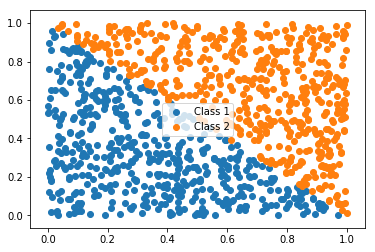

In [2]:
random_numbers = np.random.rand(1000)
N = 1000
tmp_c1 = []
tmp_c2 = []

for i in range(N):
    v_tmp = np.random.rand(2)
    
    if (v_tmp[0] + v_tmp[1] <= 1):
        tmp_c1.append(v_tmp)
    else:
        tmp_c2.append(v_tmp)

## Synthetic data for two classes
data_c1 = np.array(tmp_c1)
data_c2 = np.array(tmp_c2)

plt.scatter(data_c1[:,0], data_c1[:,1], label = 'Class 1')
plt.scatter(data_c2[:,0], data_c2[:,1], label = 'Class 2')
plt.legend()

### Applying fuzzy clustering

In [3]:
fc1 = FuzzyClustering(data_c1)
fc2 = FuzzyClustering(data_c2)

In [4]:
## finding centers
fc1.extractClusteringCenters()
centers_c1 = fc1.getDenormalizedClusterCenters()
fc2.extractClusteringCenters()
centers_c2 = fc2.getDenormalizedClusterCenters()

In [5]:
centers_c1, centers_c2

(array([[0.33842352, 0.27990123],
        [0.11209975, 0.65583029],
        [0.68216462, 0.09888761]]), array([[0.75319597, 0.65911254],
        [0.37009245, 0.85547622],
        [0.90855186, 0.29831475]]))

### Plotting resulting cluster centers

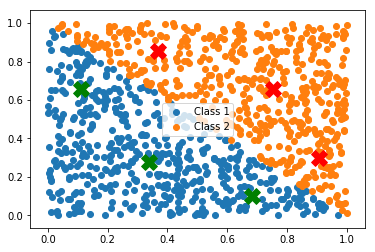

In [6]:
plt.scatter(data_c1[:,0], data_c1[:,1], label = 'Class 1')
plt.scatter(data_c2[:,0], data_c2[:,1], label = 'Class 2')

## Add centers of class 1
for cs in centers_c1:
    plt.scatter(cs[0], cs[1], marker = 'X', color = 'green', s = 250)

## Add centers of class 2
for cs in centers_c2:
    plt.scatter(cs[0], cs[1], marker = 'X', color = 'red', s = 250)

plt.legend()

## Use QPSO to optimize the rules

In [ ]:
qpso = ExtractRulesQPSO(30, 50, 2 * (len(centers_c1) + len(centers_c2)))

In [ ]:
qpso.solver([centers_c1, centers_c2], [data_c1, data_c2])

In [ ]:
qpso.best_particle

### Show rules for class 1

In [ ]:
centers_c1

In [ ]:
xs = np.linspace(0, 1, 1000)
    
plt.plot(xs, ExtractRulesQPSO._expMembership(xs, centers_c1[0][0], qpso.best_particle[0]), label = 'x1')
plt.plot(xs, ExtractRulesQPSO._expMembership(xs, centers_c1[0][1], qpso.best_particle[1]), label = 'x2')
plt.legend()

In [ ]:
plt.plot(xs, ExtractRulesQPSO._expMembership(xs, centers_c1[1][0], qpso.best_particle[2]), label = 'x1')
plt.plot(xs, ExtractRulesQPSO._expMembership(xs, centers_c1[1][1], qpso.best_particle[3]), label = 'x2')
plt.legend()

In [ ]:
plt.plot(xs, ExtractRulesQPSO._expMembership(xs, centers_c1[2][0], qpso.best_particle[4]), label = 'x1')
plt.plot(xs, ExtractRulesQPSO._expMembership(xs, centers_c1[2][1], qpso.best_particle[5]), label = 'x2')
plt.legend()

### Show rules for class 2

In [ ]:
centers_c2

In [ ]:
plt.plot(xs, ExtractRulesQPSO._expMembership(xs, centers_c2[0][0], qpso.best_particle[6]), label = 'x1')
plt.plot(xs, ExtractRulesQPSO._expMembership(xs, centers_c2[0][1], qpso.best_particle[7]), label = 'x2')
plt.legend()

In [ ]:
plt.plot(xs, ExtractRulesQPSO._expMembership(xs, centers_c2[1][0], qpso.best_particle[8]), label = 'x1')
plt.plot(xs, ExtractRulesQPSO._expMembership(xs, centers_c2[2][1], qpso.best_particle[9]), label = 'x2')
plt.legend()

In [ ]:
plt.plot(xs, ExtractRulesQPSO._expMembership(xs, centers_c2[2][0], qpso.best_particle[10]), label = 'x1')
plt.plot(xs, ExtractRulesQPSO._expMembership(xs, centers_c2[2][1], qpso.best_particle[11]), label = 'x2')
plt.legend()